# Learning to Take a Break
## Environment setup

General imports:

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rcParams.update({
    "text.usetex": True,
})
%config InlineBackend.figure_format = 'retina'

import scipy.interpolate

import lvml
from lvml.experiment.analysis import *

RANDOM_STATE = 0
lvml.random_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)


## Characteristic behavior

Init LV simulator:

In [2]:
schematic_lv = lvml.LotkaVolterraDynamicalSystem(
    alpha=1,
    beta=[2.1]*5,
    gamma=1e-1,
    delta=1e-2,
)

myopic_recommender = lvml.StationaryRecommender(
    p_fb=0,
    predicted_ratings=[1],
    true_ratings=[1],
    softmax_t=1,
)

schematic_ivp = lvml.IVP(
    y_0=[6,0.75],
    T=100,
)

Simulate ODE:

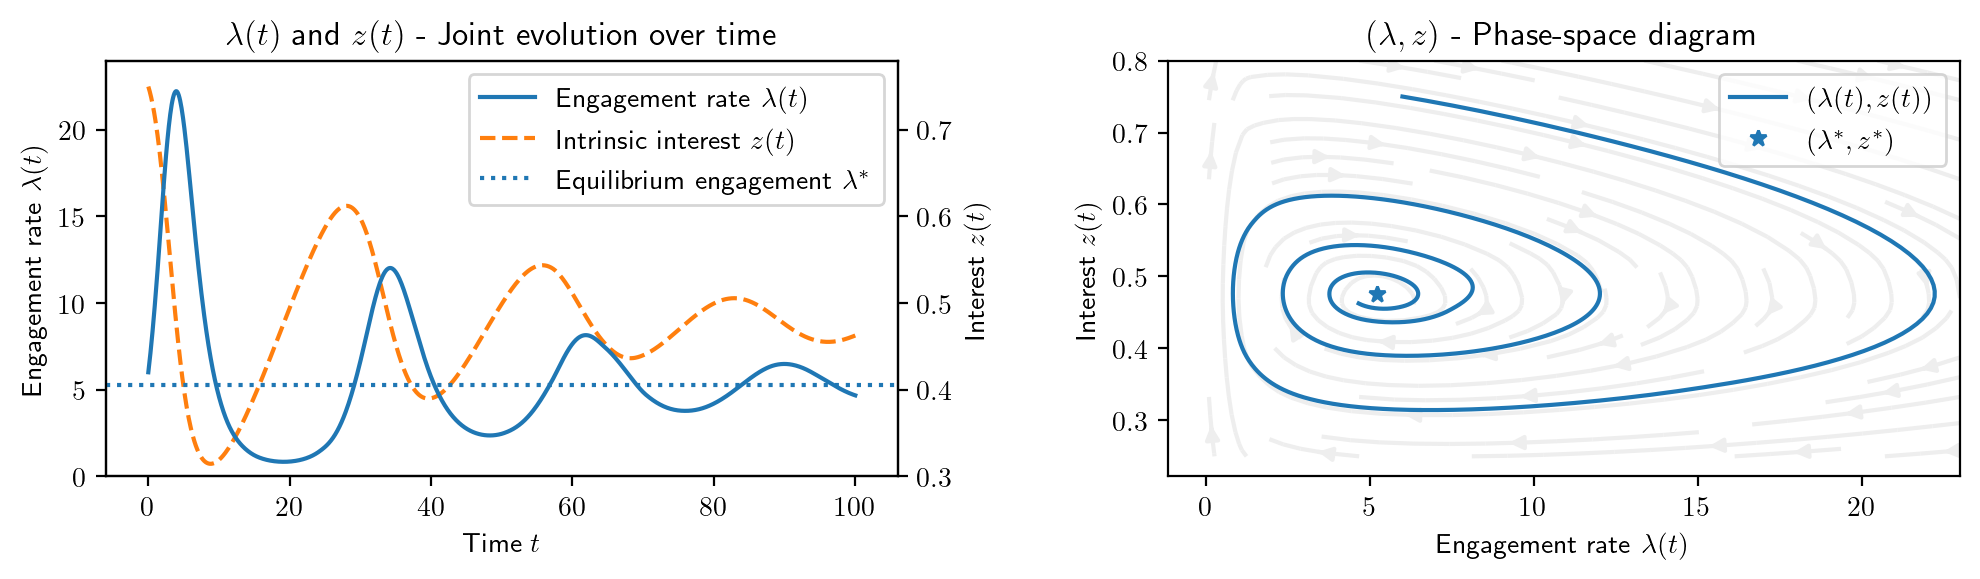

In [3]:
res = schematic_lv.simulate_ode(schematic_ivp, myopic_recommender, num_steps=1000)
    
fig,axs = create_fig(1,2)

def plot_time_evolution(ax, frame=None, full_labels=True):
    ax.clear()
    ax.plot(
        res.t[:frame],
        res.y[0][:frame],
        label=r'Engagement rate '*full_labels + r'$\lambda(t)$',
        color='tab:blue',
    )
    ax.set_ylim([0,24])
    ax.set_xlim([-6,106])
    ax.set_zorder(10)
    ax.patch.set_visible(False)
    ax0_twinx = ax.twinx()
    ax0_twinx.clear()
    ax0_twinx.plot(
        res.t[:frame], res.y[1][:frame],
        label='Intrinsic interest '*full_labels + r'$z(t)$',
        color='tab:orange',
        linestyle='--',
        zorder=-1,
    )
    ax0_twinx.set_ylim([0.3,0.78])

    ax.axhline(
        myopic_recommender.equilibrium(schematic_lv)[0],
        color='tab:blue',
        linestyle=':',
        label=r'Equilibrium engagement '*full_labels + r'$\lambda^*$',
        zorder=-2
    )

    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax0_twinx.get_legend_handles_labels()
    ax.legend(
        lines[:1] + lines2 + lines[1:],
        labels[:1] + labels2 + labels[1:],
        loc='upper right',
    )

    ax.set(
        xlabel='Time $t$',
        ylabel=r'Engagement rate $\lambda(t)$',
        title=r'$\lambda(t)$ and $z(t)$ - Joint evolution over time',
    )
    ax0_twinx.set_ylabel(r'Interest $z(t)$')
    return ax,ax0_twinx
    

def plot_phase_space(ax, frame=None):
    ax.clear()
    ax.plot(res.y[0][:frame], res.y[1][:frame], label=r'$(\lambda(t),z(t))$', color='tab:blue')
    ax.set(
        xlabel=r'Engagement rate $\lambda(t)$',
        ylabel=r'Interest $z(t)$',
        title=r'$(\lambda,z)$ - Phase-space diagram',
    )

    n,q = np.meshgrid(
        np.linspace(0.1,23,20),
        np.linspace(0.25,0.8,15),
    )

    u = 1
    v = -1

    nq=np.stack([n,q],axis=0)

    lv_A = np.zeros((2,2))
    lv_A[0,1] = schematic_lv.beta[0]
    lv_A[1,0] = -schematic_lv.delta
    lv_A[1,1] = -schematic_lv.gamma
    lv_r = np.zeros(2)
    lv_r[0] = -schematic_lv.alpha
    lv_r[1] = schematic_lv.gamma

    uv = nq*(np.einsum('ij,jkl',lv_A, nq) + np.expand_dims(np.expand_dims(lv_r, axis=-1), axis=-1))
    u,v = uv/np.linalg.norm(uv,axis=0)

    ax.streamplot(n,q,u,v, density=0.7, arrowsize=1, color='#EEE', zorder=-1)
    ax.plot(
        myopic_recommender.equilibrium(schematic_lv)[0],
        myopic_recommender.equilibrium(schematic_lv)[1],
        '*',
        color='tab:blue',
        label=r'$(\lambda^*, z^*)$',
    )
    ax.legend(
        loc='upper right',
    )
    return ax
    
plot_time_evolution(axs[0])
plot_phase_space(axs[1])
fig.download('schematic_lv_diagram.pdf')

Presentation animation

In [4]:
# import os
# from tqdm.auto import tqdm
# os.mkdir('./output/animation/1')
# os.mkdir('./output/animation/2')
# for frame in tqdm(range(2,1200,5)):
#     fig,ax = create_fig(figsize=(12,4))
#     plot_time_evolution(ax,frame)[0].set_title('')
#     fig.savefig(f'./output/animation/1/out_{frame:05}.png', dpi=200)
#     plt.close()
#     fig,axs = create_fig(1,2,figsize=(10,4))
#     plot_time_evolution(axs[0],frame)
#     plot_phase_space(axs[1],frame)
#     fig.savefig(f'./output/animation/2/out_{frame:05}.png', dpi=200)
#     plt.close()

## Bash: for i in {1..2}; do echo $i; ffmpeg -framerate 24 -pattern_type glob -i "./$i/*.png" -c:v libx264 -pix_fmt yuv420p out_$i.mp4; done


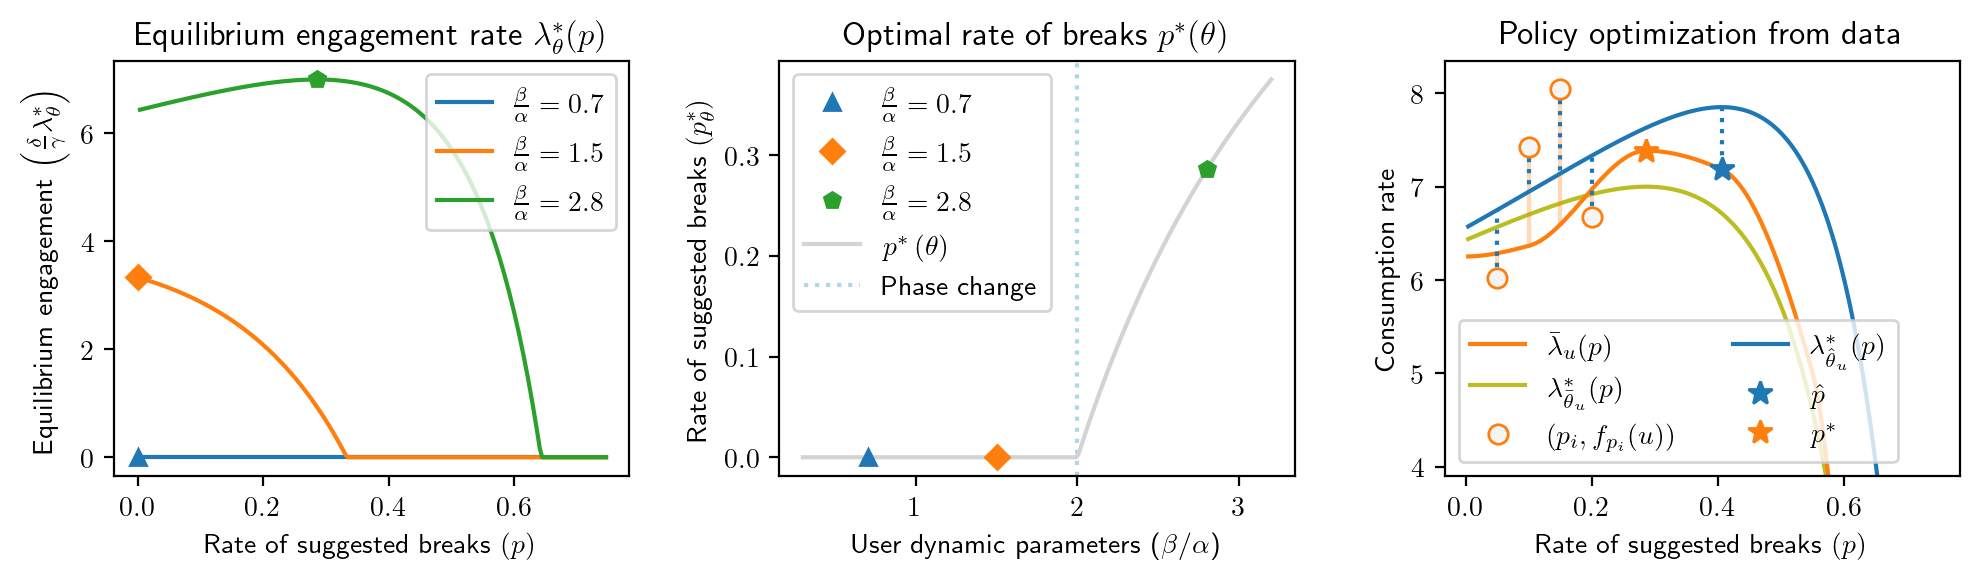

In [5]:
# lv_eq = lambda r,p: np.clip((1/(1-p))*(1-r/(1-p)), a_min=0, a_max=None)

# p = np.linspace(0,1,200)[1:-1]
p_vec = np.linspace(0,0.75,200)[1:-1]

fig,axs = create_fig(1,3,tight_layout={'w_pad':2})

markers = ['^','D','p']

ab_vals = [1/0.7, 1/1.5, 1/2.8]
gd = schematic_lv.gamma/schematic_lv.delta

def plot_equilibrium_curve(ax, show_marker=True, legend_args=None, p_vec=p_vec):
    for (ab,c,m) in zip(ab_vals,matplotlib.colors.TABLEAU_COLORS,markers):
        if 1/ab<=2:
            if 1/ab<=1:
                regime = 'Churn regime'
            else:
                regime = 'Myopic regime'
        else:
            regime = 'Breaks are beneficial'
        # Equilibrium curve
        ax.plot(
            p_vec,
            lv_eq_f(ab,gd,p_vec),
            color=c,
            label=r'$\frac{\beta}{\alpha}=%.1f$' % (1/ab),
        )
        # Optimal policy
        if show_marker:
            ax.plot(
                p_opt_f(ab),
                opt_eq_f(ab, gd),
                linestyle='',
                marker=m,
                color=c,
            )
    ax.set(
        xlabel=r'Rate of suggested breaks $\left(p\right)$',
        ylabel=r'Equilibrium engagement $\left(\frac{\delta}{\gamma} \lambda^*_\theta \right)$',
        title=r'Equilibrium engagement rate $\lambda^*_\theta(p)$',
    )
    if legend_args is None:
        legend_args = {
            'loc': 'upper right',
        }
    ax.legend(**legend_args)
    return ax

plot_equilibrium_curve(axs[0])
    
#####

def plot_p_opt_curve(ax):
    for (ab,c,m) in zip(ab_vals,matplotlib.colors.TABLEAU_COLORS,markers):
        ax.plot(
            1/ab,
            p_opt_f(ab),
            linestyle='',
            marker=m,
            color=c,
            label=r'$\frac{\beta}{\alpha}=%.1f$' % (1/ab),
            # label=r'${\beta}/{\alpha}=%.1f$' % (1/ab),
        )

    b_vec = np.linspace(0.3,3.2,200)
    ab_vec = 1/b_vec
    ax.plot(
        b_vec,
        p_opt_f(ab_vec),
        '-',
        color='lightgrey',
        zorder=-1,
        # label=r'$p^*\left(\frac{\beta}{\alpha}\right)$',
        # label=r'$p^*\left({\beta}/{\alpha}\right)$',
        label=r'$p^*\left(\theta\right)$',
    )
    ax.axvline(
        2,
        color='lightblue',
        zorder=-2,
        linestyle=':',
        label='Phase change'
    )
    ax.set(
        xlabel=r'User dynamic parameters ($\beta/\alpha$)',
        ylabel=r'Rate of suggested breaks $\left(p^*_\theta\right)$',
        title=r'Optimal rate of breaks $p^*(\theta)$',
    )
    ax.legend()
    return ax

plot_p_opt_curve(axs[1])

####

ax=axs[2]

def plot_optimization_from_data(ax, legend_labels=None, legend_args=None):
    ab = 1/2.8

    true_c = 'tab:orange'
    fit_c = 'tab:olive'
    est_c = 'tab:blue'

    data_points = {
        p: lv_eq_f(ab,gd,p)*(1+skew)
        for p,skew in zip(
            [0.05, 0.1, 0.15, 0.2],
            (np.array([-0.12, 0.04, 0.1, -0.08])+0.05)*1.2,
        )
    }
    
    if legend_labels is None:
        legend_labels = {
            'true_response': r'$\bar{\lambda}_u(p)$',
            'closest_lv': r'$\lambda^*_{\bar{\theta}_u}(p)$',
            'estimated_lv': r'$\lambda^*_{\hat{\theta}_u}(p)$',
            'predicted_ltv': r'$\left(p_i, f_{p_i}(u)\right)$',
            'selected_policy': r'$\hat{p}$',
            'optimal_policy': r'$p^*$',
        }
    
    if legend_args is None:
        legend_args = {'ncol':2}


    oracle_params = (ab,gd)
    est_params = (
        lvml.LotkaVolterraOptimalForcedBreaksPolicy
        .lv_params_from_predictions(data_points)
    )

    rng = np.random.default_rng(seed=RANDOM_STATE)
    interp_points = np.hstack([
        [0.0,0.1,0.55,0.65, 0.8,0.99],
        [p_opt_f(est_params[0]), p_opt_f(ab)],
    ])
    argsort = np.argsort(interp_points)
    interp_skew = rng.normal(loc=-4e-2, scale=1e-1,size=len(interp_points))
    interp_skew[-1] = 0.055
    interp_skew[-2] = 0.07
    interp_skew[1] = -0.05
    interp_skew[2] = 0.09
    interp_skew[3] = 0.2
    interp_curve = scipy.interpolate.pchip_interpolate(
        xi=interp_points[argsort],
        yi=(lv_eq_f(ab,gd,interp_points)*(1+interp_skew)).clip(min=0)[argsort],
        x=p_vec
    )
    ax.plot(p_vec, interp_curve, color=true_c, label=legend_labels['true_response'])
    interp_f = scipy.interpolate.interp1d(
        x=p_vec,
        y=interp_curve,
    )


    for p in data_points:
        ax.plot(
            [p,p],
            [interp_f(p), data_points[p]],
            color=true_c,
            alpha=0.3,
        )
        ax.plot(
            [p,p],
            [data_points[p], lv_eq_f(*est_params,p_fb=p)],
            color=est_c,
            linestyle=':'
        )

    ax.plot(
        p_vec,
        lv_eq_f(*oracle_params,p_fb=p_vec),
        color=fit_c,
        linestyle='-',
        label=legend_labels['closest_lv'],
        zorder=-1,
    )

    ax.plot(
        *np.array(list(data_points.items())).T,
        'o',
        color='whitesmoke',
        markersize=7,
        markeredgecolor=true_c,
        label=legend_labels['predicted_ltv'],
    )

    ax.plot(
        p_vec,
        lv_eq_f(*est_params,p_fb=p_vec),
        color=est_c,
        label=legend_labels['estimated_lv'],
    )
    
    p_fb_opt_est = p_opt_f(est_params[0])
    ax.plot(
        [p_fb_opt_est]*2,
        [
            lv_eq_f(*est_params,p_fb=p_fb_opt_est),
            interp_f(p_fb_opt_est),
        ],
        ':',
        color=est_c,
    )

    ax.plot(
        p_fb_opt_est,
        interp_f(p_fb_opt_est),
        '*',
        color=est_c,
        markersize=9,
        label=legend_labels['selected_policy'],
    )

    p_fb_opt_oracle = p_opt_f(oracle_params[0])
    ax.plot(
        p_fb_opt_oracle,
        interp_f(p_fb_opt_oracle),
        '*',
        color=true_c,
        markersize=9,
        label=legend_labels['optimal_policy'],
    )

    ax.set(ylim=[3.9,8.35])

    ax.legend(**legend_args)
    ax.set(
        title=f'Policy optimization from data',
        xlabel=r'Rate of suggested breaks $\left(p\right)$',
        ylabel='Consumption rate',
    )
    return ax

plot_optimization_from_data(ax=axs[2])

fig.download('schematic_equilibrium_analysis.pdf')

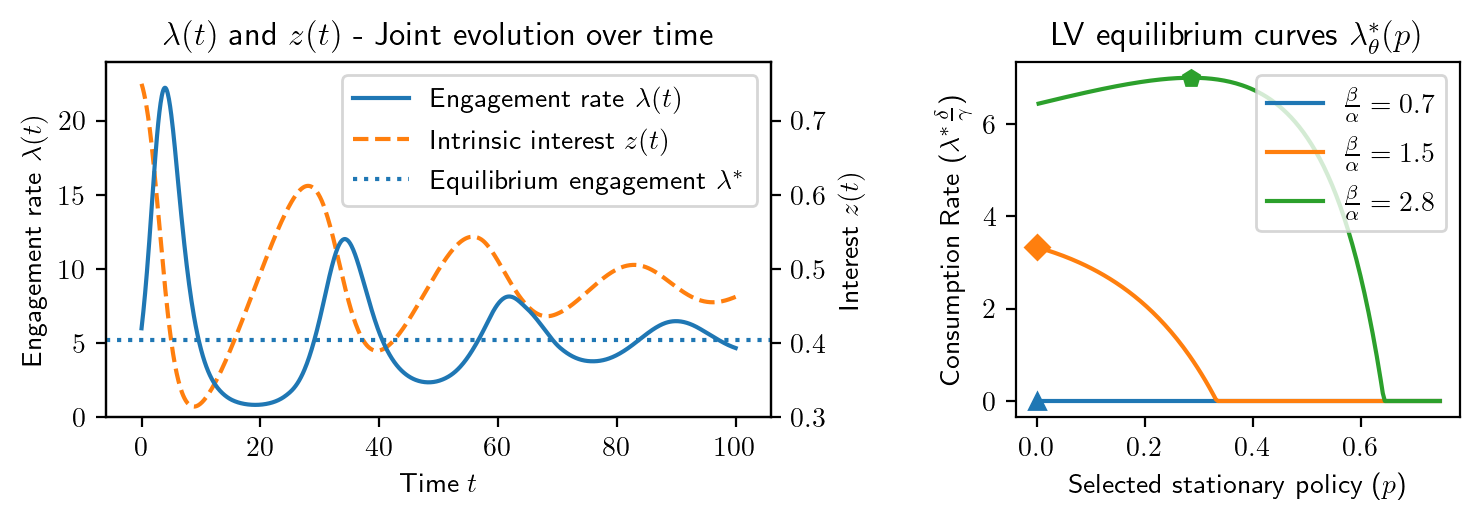

In [6]:
fig,axs = create_fig(
    1,2,
    gridspec_kw=dict(width_ratios=[3, 2]),
    tight_layout=dict(w_pad=2.5),
    figsize=(7.5,2.7),
)
plot_time_evolution(axs[0])
plot_equilibrium_curve(axs[1])
axs[1].set(
    title=r'LV equilibrium curves $\lambda^*_{\theta}(p)$',
    ylabel=r'Consumption Rate ($\lambda^* \frac{\delta}{\gamma}$)',
    xlabel=r'Selected stationary policy ($p$)',
    
)
fig.download('poster_schematic_lv.pdf')

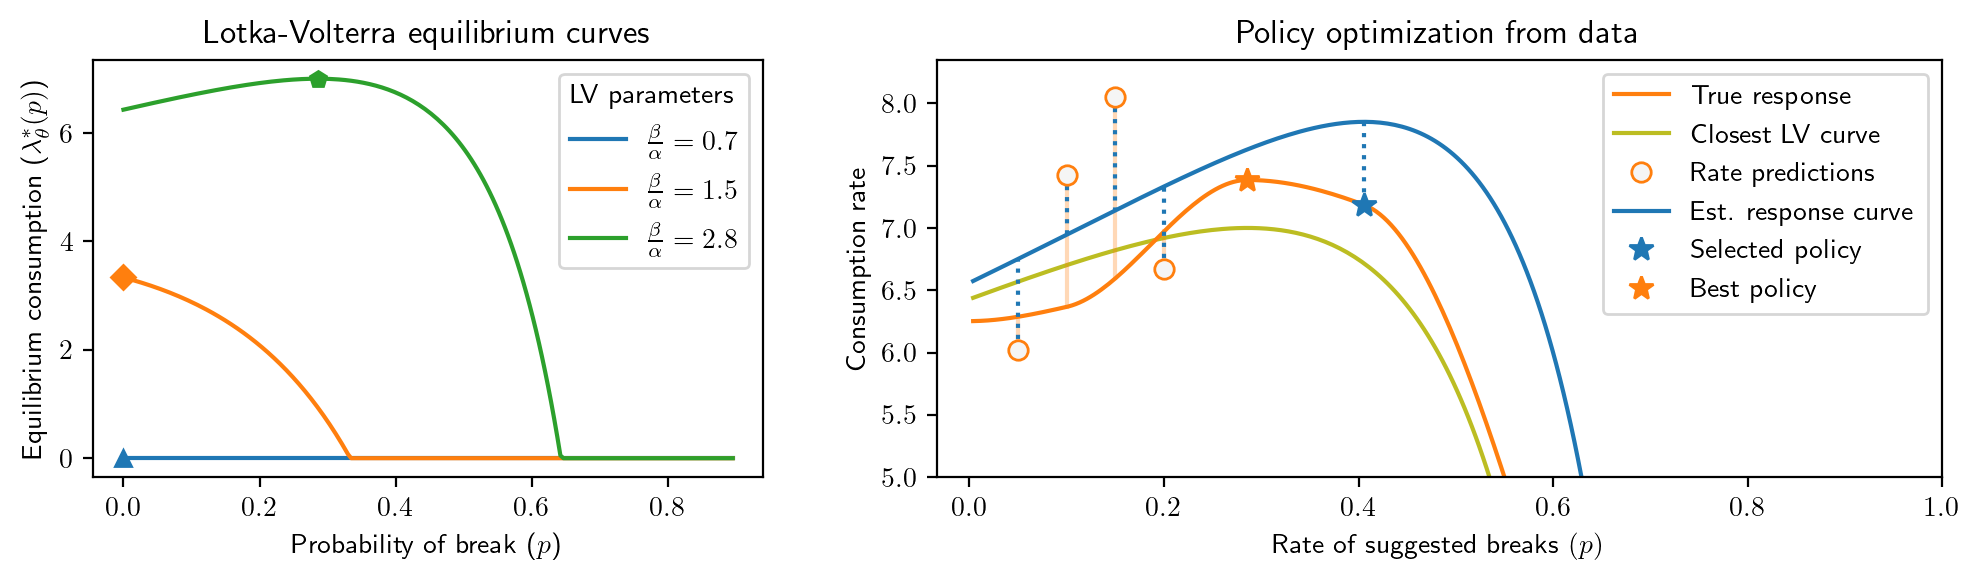

In [7]:
fig,axs = create_fig(
    1,2,
    gridspec_kw=dict(width_ratios=[2, 3]),
    # tight_layout=dict(w_pad=2.5),
    # figsize=(10,3),
)
plot_equilibrium_curve(
    axs[0],
    legend_args={
        'loc': 'upper right',
        'title': 'LV parameters',
    },
    p_vec=np.linspace(0,0.9,200)[:-1],
)
axs[0].set(
    title=r'Lotka-Volterra equilibrium curves',
    ylabel=r'Equilibrium consumption ($\lambda^*_\theta(p)$)',
    #($\frac{\delta}{\gamma} \lambda^*_\frac{\alpha}{\beta}(p)$)',
    xlabel=r'Probability of break ($p$)',
    # xlim=(None,0.9)
)
plot_optimization_from_data(
    ax=axs[1],
    legend_labels = {
        'true_response': r'True response',
        'closest_lv': r'Closest LV curve',
        'estimated_lv': r'Est. response curve',
        'predicted_ltv': r'Rate predictions',
        'selected_policy': r'Selected policy',
        'optimal_policy': r'Best policy',
    },

    legend_args = {'ncol': 1}
)
axs[1].set(
    xlim=(None,1),
    ylim=(5,None),
)
fig.download('proposal_schematic_lv.pdf')

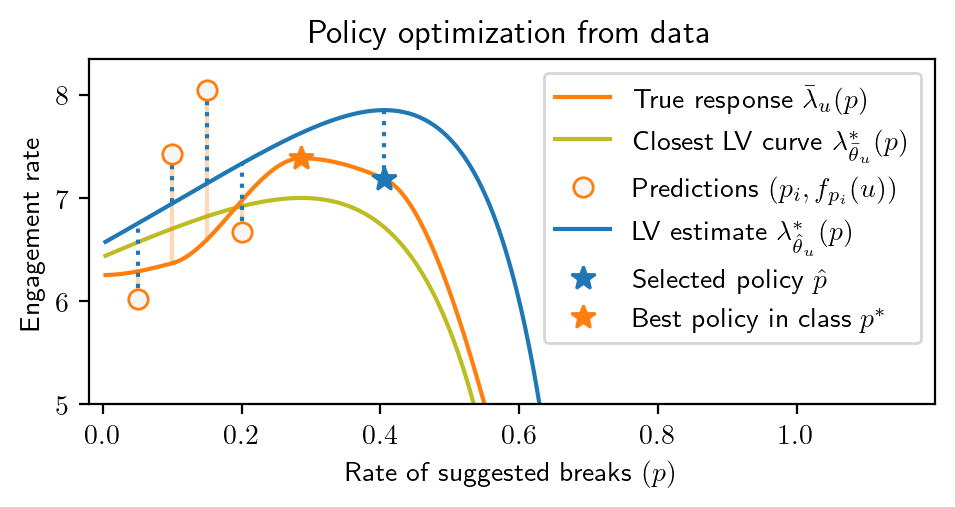

In [8]:
fig,ax=subplots_latex(
    row_width_type='columnwidth',
    row_height_factor=0.16,
)
plot_optimization_from_data(
    ax=ax,
    legend_labels = {
        'true_response': r'True response $\bar{\lambda}_u(p)$',
        'closest_lv': r'Closest LV curve $\lambda^*_{\bar{\theta}_u}(p)$',
        'estimated_lv': r'LV estimate $\lambda^*_{\hat{\theta}_u}(p)$',
        'predicted_ltv': r'Predictions $\left(p_i, f_{p_i}(u)\right)$',
        'selected_policy': r'Selected policy $\hat{p}$',
        'optimal_policy': r'Best policy in class $p^*$',
    },
    legend_args = {'ncol': 1}
)
ax.axhline(0,zorder=-1,color='lightgrey')
ax.set(
    xlim=(-0.02,1.199),
    ylim=(5,None),
    ylabel='Engagement rate',
)
fig.download('policy_optimization_from_data.pdf')

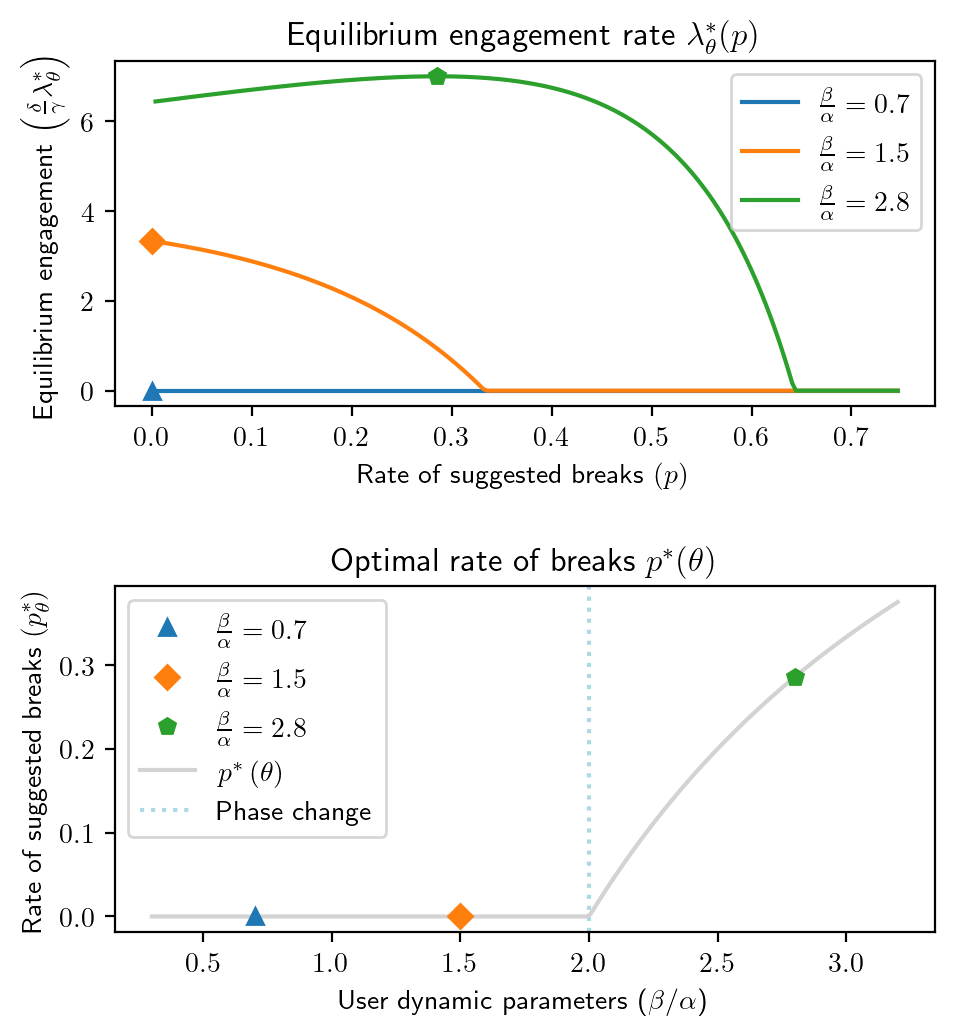

In [9]:
fig,axs=subplots_latex(
    2,1,
    row_width_type='columnwidth',
    row_height_factor=0.16,
    tight_layout=None,
    # gridspec_kw={'height_ratios':[3,3]},
)
axs_it=iter(axs.ravel())
# plot_time_evolution(ax=next(axs_it))
plot_equilibrium_curve(ax=next(axs_it))
plot_p_opt_curve(ax=next(axs_it))
# axs[1].legend(['a','b','c','d','e'])#ncol=2)
fig.tight_layout(h_pad=2)
fig.download('lv_equilibrium_analysis_columnwidth.pdf')

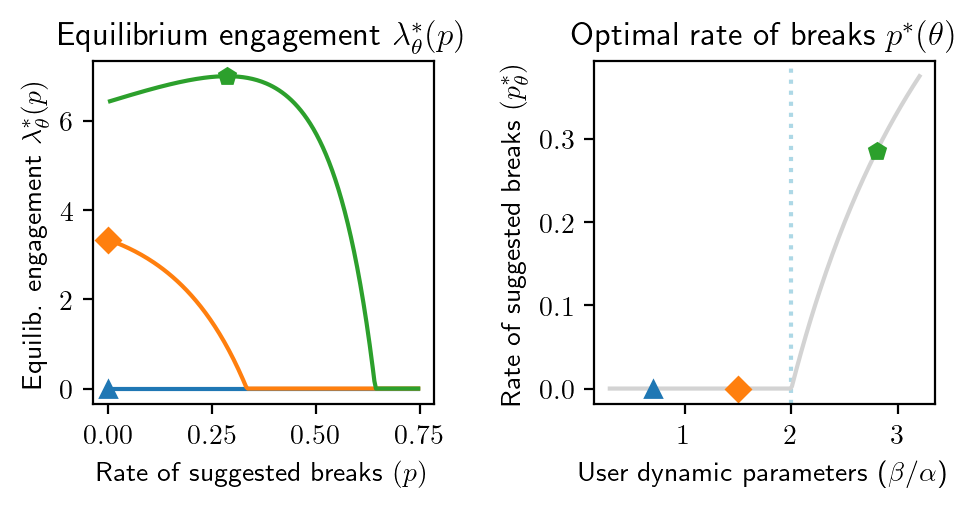

In [10]:
fig,axs=subplots_latex(
    1,2,
    row_width_type='columnwidth',
    row_height_factor=0.16,
    tight_layout=None,
    # gridspec_kw={'height_ratios':[3,3]},
)
axs_it=iter(axs.ravel())
# plot_time_evolution(ax=next(axs_it))
ax=next(axs_it)
plot_equilibrium_curve(ax=ax)
ax.set(
    title=r'Equilibrium engagement $\lambda^*_\theta(p)$',
    ylabel=r'Equilib. engagement $\lambda^*_\theta(p)$',
)
ax.get_legend().remove()

ax=next(axs_it)
plot_p_opt_curve(ax=ax)
ax.get_legend().remove()

# axs[0].legend(None)
# axs[1].legend(['a','b','c','d','e'])#ncol=2)
fig.tight_layout(w_pad=2)
fig.download('lv_equilibrium_analysis_columnwidth.pdf')

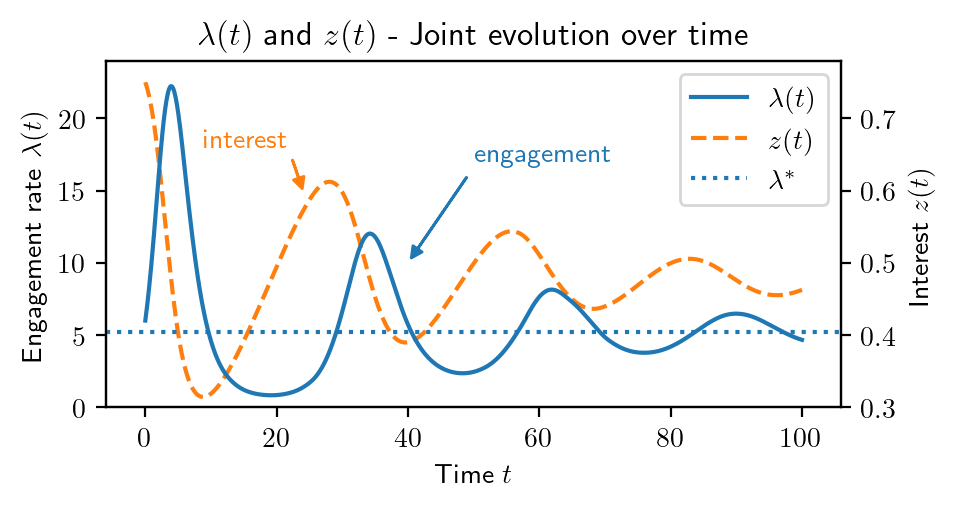

In [11]:
fig,ax=subplots_latex(
    1,1,
    row_width_type='columnwidth',
    row_height_factor=0.16,
)
plot_time_evolution(ax=ax, full_labels=False)
add_arrow = lambda ax, color, **kwargs: ax.annotate(
    arrowprops=dict(
        facecolor=color,
        width=0.1,
        edgecolor=color,
        headwidth=4,
        headlength=4,
        shrink=0.05,
    ),
    color=color,
    fontweight='bold',
    **kwargs,
)

add_arrow(
    ax=ax,
    color='tab:blue',
    text='engagement',
    xy=(40,10),
    xytext=(50,17),
)

add_arrow(
    ax=ax,
    color='tab:orange',
    text='interest',
    xy=(24,15),
    xytext=(9,18),
)
fig.download('lv_consumption_cycle.pdf')

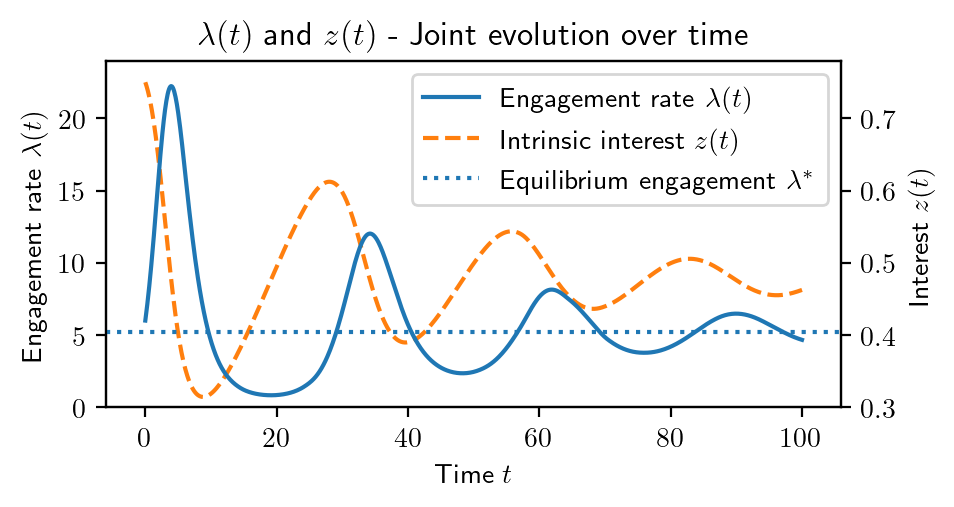

In [12]:
fig,ax=subplots_latex(
    1,1,
    row_width_type='columnwidth',
    row_height_factor=0.16,
)
plot_time_evolution(ax=ax)
fig.download('lv_consumption_cycle.pdf')

## Supporting figures for proofs

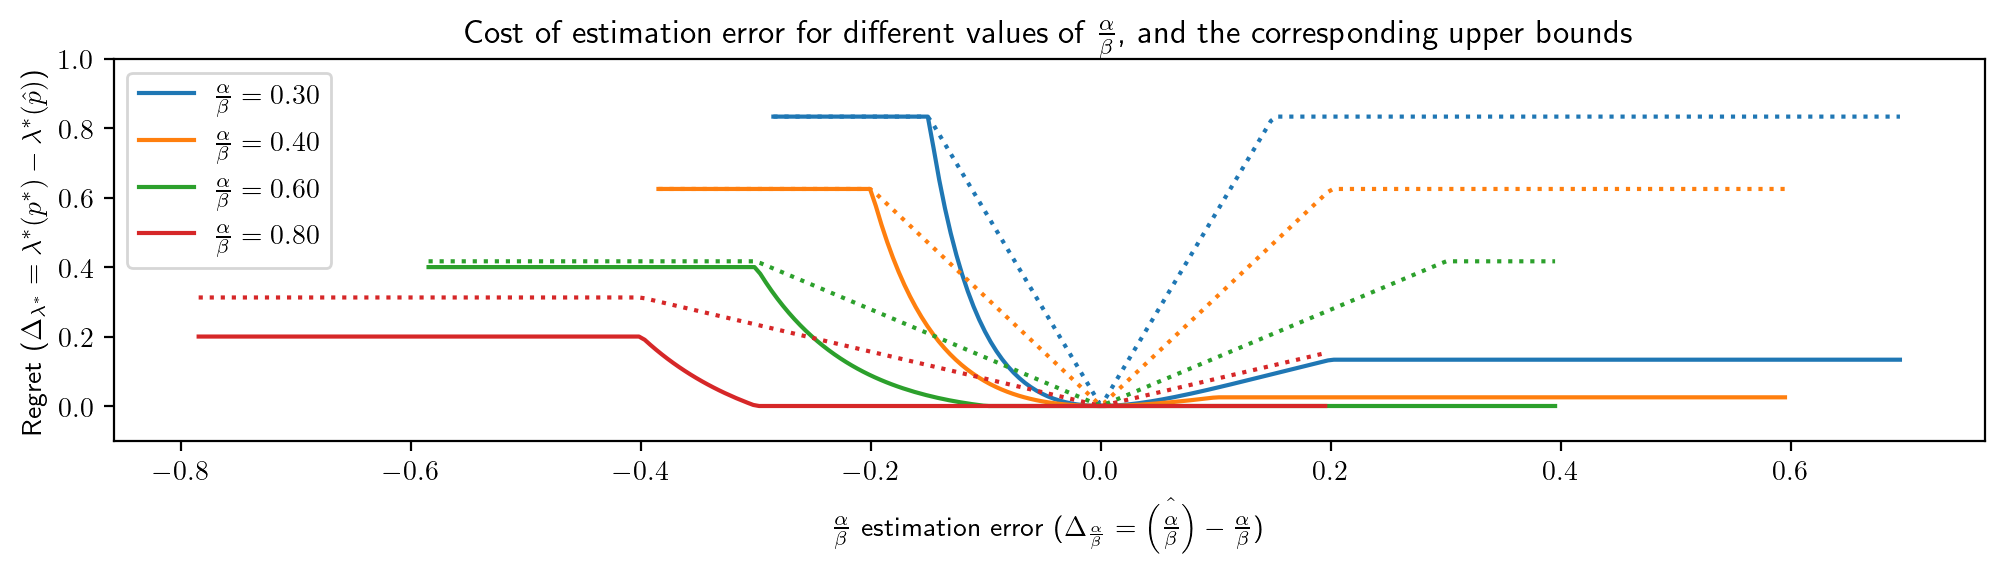

In [13]:
r_hat = np.linspace(0.01,1,200)[1:-1]
fig,ax=subplots_latex(
    row_width_type='textwidth',
    row_height_factor=0.18,
)

for r in [0.3, 0.4, 0.6, 0.8]:
    true_opt = (1/(4*r))*(r<=0.5) + (1-r)*(r*0+1)*(r>0.5) 
    est_opt = np.clip(
        (1/(2*r_hat))*(1-r/(2*r_hat))*(r_hat<=0.5) + (1-r)*(r_hat*0+1)*(r_hat>0.5),
        a_min=0,
        a_max=None,
    )
    eps = r_hat-r
    line = ax.plot(eps, true_opt-est_opt, label=r'$\frac{\alpha}{\beta}=%.2f$' % r)
    c = line[0].get_color()
    ax.plot(eps, np.clip((1/(2*r**2))*np.abs(eps), a_min=None, a_max=1/(4*r)), ':', color=c)
    
ax.legend()
ax.set(
    ylim=(-0.1,1),
    xlabel=r'$\frac{\alpha}{\beta}$ estimation error ($\Delta_\frac{\alpha}{\beta}=\hat{\left(\frac{\alpha}{\beta}\right)} - \frac{\alpha}{\beta}$)',
    ylabel=r'Regret ($\Delta_{\lambda^*}=\lambda^*(p^*)-\lambda^*(\hat{p})$)',
    title=r'Cost of estimation error for different values of $\frac{\alpha}{\beta}$, and the corresponding upper bounds',
)
fig.tight_layout()
fig.download('alpha_beta_error_bounds.pdf')

In [14]:

cum_avg = lambda t,x: (t[1:], np.cumsum(np.diff(t)*x[:-1])/t[1:])

build_lv = lambda beta: lvml.LotkaVolterraDynamicalSystem(
    alpha=1,
    beta=[beta]*5,
    gamma=3e-1,
    delta=3e-3,
)

build_ivp = lambda lv, recommender: lvml.IVP(
    y_0=np.array([np.random.uniform(0.8,1.2), 0.9])*recommender.equilibrium(lv),
    T=100,
)

lv = build_lv(2.7)
ivp = build_ivp(lv, myopic_recommender)

## Empirical simulation - Stochastic

In [15]:
dt = 0.01
lv = lvml.LotkaVolterraDynamicalSystem(
    alpha=dt*1.5,
    beta=dt*(np.arange(5)+1),
    gamma=dt*1e-1,
    delta=dt*1e-3,
)

predicted_ratings=np.array([3.550361125816256, 3.8597579164878644, 3.9188785002650284, 3.952254436900264, 3.7323289431609035, 3.695879539767117, 4.225372563689326, 3.8585442522961375, 3.5972850743788833, 4.2605633549838835, 2.980885544209226, 3.3717896620506034, 3.191902701442402, 4.277655474011338, 4.370519754234184, 3.961151559999169, 3.90753957025024, 3.8967022305653303, 4.503076293595809, 4.012111602305471, 4.067141439914146, 3.9436914582872915, 3.811343813773409, 4.39614979755028, 4.035760151990023, 3.523465050096533, 3.7520600219635667, 3.845768035906705, 2.9198468492392067, 3.1368093678825772, 3.956548335248602, 3.4738394704160775, 3.8092559807999375, 3.8153075763594373, 4.311781005502261, 3.957921140712275, 3.4714008710662863, 3.219603244138496, 3.2825569110275685, 3.1545850282772805, 3.7853872427449433, 4.100312084605467, 4.022960855502739, 4.5214176537582365, 3.4196152056967484, 3.927105971699967, 3.5868656886674235, 3.9290999087088885, 3.781426465035388, 3.2593181384588035, 4.263754004194251, 3.338321546254274, 4.115374365205509, 3.71879531018862, 4.081441736846894, 3.838641814896115, 4.149564860583239, 3.386337020000275, 3.1043347705096154, 3.815283735803373, 3.9445448994421444, 3.94338593300773, 4.330473828698682, 3.329051060587971, 3.975747309653658, 3.8208651770374122, 3.232502041560569, 3.859151047303385, 4.285591067327205, 3.864660241432277, 3.379399416405687, 4.191187146292468, 3.2919808429331967, 4.1426812353661235, 3.3177894528661307, 3.5712316641079056, 3.3176439901051715, 3.642115334678205, 4.207286502640922, 4.344647288222194, 4.261959207195357, 4.342128203419927, 3.6727585420038604, 3.827898872208006, 4.032965386789573, 3.5327300942679964, 3.9028613148374567, 3.6443983823369295, 3.999460072030241, 3.9252096788529216, 3.3119539697294247, 3.9048474344788584, 3.6093995460465846, 3.8031476579271857, 3.668873002576288, 3.829485293377741, 3.7669692288779206, 3.6424760039998105, 3.7160891445312876, 3.435708360607382, 3.8502764913554666, 4.202346725979188, 3.8385895443384364, 3.9820417584630885, 4.063666956444078, 3.289354524344484, 3.8877323786695706, 4.4449641476433115, 3.3802178321875123, 3.5895297529886063, 4.108481489137391, 3.3311633823886324, 4.408858279221328])
true_ratings=np.array([3.0, 4.0, 4.0, 3.0, 5.0, 2.0, 5.0, 4.0, 4.0, 4.0, 2.0, 2.0, 2.0, 4.0, 4.0, 4.0, 4.0, 3.0, 4.0, 4.0, 4.0, 5.0, 3.0, 5.0, 4.0, 3.0, 4.0, 4.0, 2.0, 2.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 4.0, 1.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 2.0, 4.0, 2.0, 4.0, 5.0, 4.0, 3.0, 4.0, 4.0, 3.0, 4.0, 5.0, 4.0, 4.0, 4.0, 4.0, 5.0, 4.0, 4.0, 4.0, 5.0, 4.0, 2.0, 4.0, 4.0, 5.0, 3.0, 4.0, 2.0, 4.0, 3.0, 3.0, 4.0, 3.0, 4.0, 4.0, 5.0, 5.0, 5.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 3.0, 4.0, 5.0, 4.0, 3.0, 4.0, 4.0, 4.0, 2.0, 3.0, 5.0, 5.0, 5.0, 2.0, 4.0, 4.0, 4.0, 4.0, 5.0, 4.0, 2.0, 4.0, 5.0, 3.0])


In [16]:
rec = lvml.StationaryRecommender(
    p_fb=0.3,
    predicted_ratings=predicted_ratings,
    true_ratings=true_ratings,
    softmax_t=1,
)

ivp = lvml.IVP(
    y_0 = rec.equilibrium(lv)*(1+np.random.uniform(-1,1,size=2)*0.1),
    T = 100,
)

batch_size=1, empirical_rate=61.68
batch_size=10, empirical_rate=65.04
batch_size=100, empirical_rate=64.93


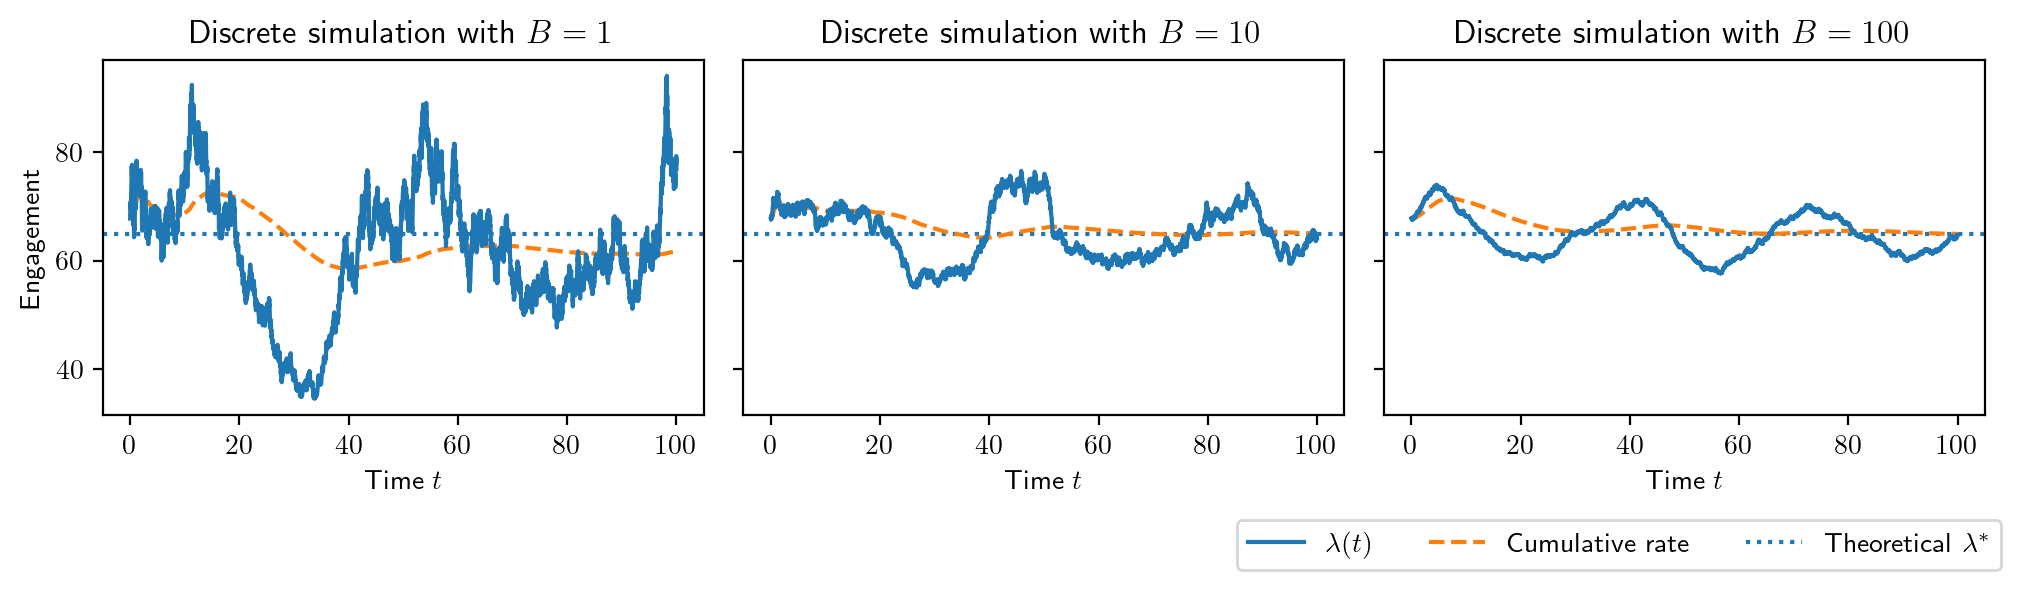

In [17]:
lvml.random_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

fig,axs=subplots_latex(
    1,3,
    row_width_type='textwidth',
    row_height_factor=0.18,
    sharex=True,
    sharey=True,
    tight_layout=dict(rect=(0,0.1,1,1))
)

for batch_size,c,ax in zip([1,10,100], matplotlib.colors.TABLEAU_COLORS, axs):
    discrete_res = lv.simulate_discrete(ivp, rec, batch_size=batch_size)
    events_df = discrete_res.events_df()
    l = (
        events_df
        ['y']
        .map(lambda arr: arr[0])
        .plot.line(
            ax=ax,
        )
    )
    (
        discrete_res.events_df()
        ['cumulative_rate']
        .plot.line(
            ax=ax,
            linestyle='--',
            zorder=-1,
        )
    )
    ax.axhline(
        rec.equilibrium(lv)[0],
        linestyle=':',
        label='Theoretical LV equilibrium',
        zorder=-2,
    )
    ax.set(
        xlabel='Time $t$',
        ylabel='Engagement',
        title=f'Discrete simulation with $B={batch_size}$',
    )
    print(f'batch_size={batch_size}, empirical_rate={discrete_res.empirical_rate():.2f}')

fig.legend(
    l.get_lines(),
    [
        '$\lambda(t)$',
        r'Cumulative rate',
        'Theoretical $\lambda^*$',
    ],
    loc='lower right',
    bbox_to_anchor=(1,0),
    ncol=3,
    bbox_transform=fig.transFigure,
)

fig.download('discrete_and_continuous_lv_simulation.pdf')

2.479371895119582


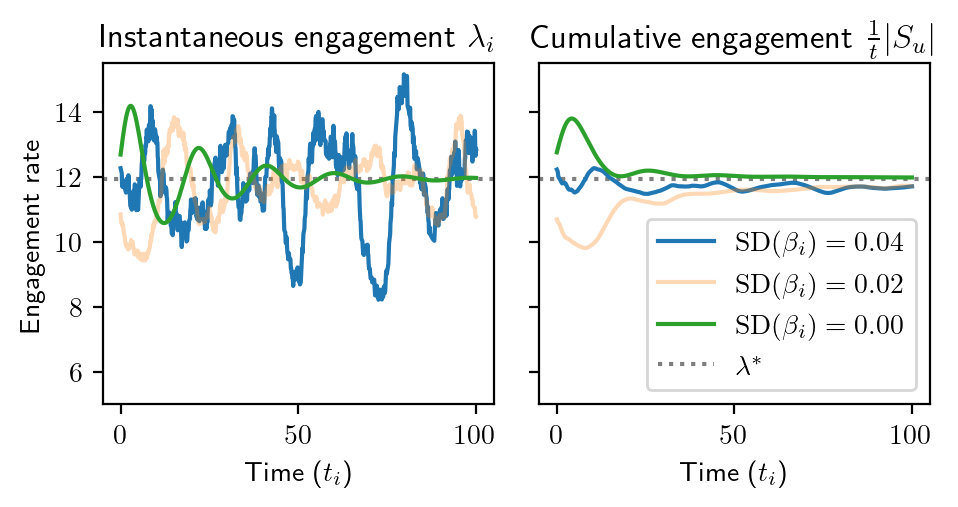

In [18]:
dt = 0.05
lv = lvml.LotkaVolterraDynamicalSystem(
    alpha=1.3*dt,
    beta=dt*(np.arange(5)+1)**2/5,
    gamma=4e-1*dt,
    delta=2e-2*dt,
)

predicted_ratings=np.array([3.550361125816256, 3.8597579164878644, 3.9188785002650284, 3.952254436900264, 3.7323289431609035, 3.695879539767117, 4.225372563689326, 3.8585442522961375, 3.5972850743788833, 4.2605633549838835, 2.980885544209226, 3.3717896620506034, 3.191902701442402, 4.277655474011338, 4.370519754234184, 3.961151559999169, 3.90753957025024, 3.8967022305653303, 4.503076293595809, 4.012111602305471, 4.067141439914146, 3.9436914582872915, 3.811343813773409, 4.39614979755028, 4.035760151990023, 3.523465050096533, 3.7520600219635667, 3.845768035906705, 2.9198468492392067, 3.1368093678825772, 3.956548335248602, 3.4738394704160775, 3.8092559807999375, 3.8153075763594373, 4.311781005502261, 3.957921140712275, 3.4714008710662863, 3.219603244138496, 3.2825569110275685, 3.1545850282772805, 3.7853872427449433, 4.100312084605467, 4.022960855502739, 4.5214176537582365, 3.4196152056967484, 3.927105971699967, 3.5868656886674235, 3.9290999087088885, 3.781426465035388, 3.2593181384588035, 4.263754004194251, 3.338321546254274, 4.115374365205509, 3.71879531018862, 4.081441736846894, 3.838641814896115, 4.149564860583239, 3.386337020000275, 3.1043347705096154, 3.815283735803373, 3.9445448994421444, 3.94338593300773, 4.330473828698682, 3.329051060587971, 3.975747309653658, 3.8208651770374122, 3.232502041560569, 3.859151047303385, 4.285591067327205, 3.864660241432277, 3.379399416405687, 4.191187146292468, 3.2919808429331967, 4.1426812353661235, 3.3177894528661307, 3.5712316641079056, 3.3176439901051715, 3.642115334678205, 4.207286502640922, 4.344647288222194, 4.261959207195357, 4.342128203419927, 3.6727585420038604, 3.827898872208006, 4.032965386789573, 3.5327300942679964, 3.9028613148374567, 3.6443983823369295, 3.999460072030241, 3.9252096788529216, 3.3119539697294247, 3.9048474344788584, 3.6093995460465846, 3.8031476579271857, 3.668873002576288, 3.829485293377741, 3.7669692288779206, 3.6424760039998105, 3.7160891445312876, 3.435708360607382, 3.8502764913554666, 4.202346725979188, 3.8385895443384364, 3.9820417584630885, 4.063666956444078, 3.289354524344484, 3.8877323786695706, 4.4449641476433115, 3.3802178321875123, 3.5895297529886063, 4.108481489137391, 3.3311633823886324, 4.408858279221328])
true_ratings=np.array([3.0, 4.0, 4.0, 3.0, 5.0, 2.0, 5.0, 4.0, 4.0, 4.0, 2.0, 2.0, 2.0, 4.0, 4.0, 4.0, 4.0, 3.0, 4.0, 4.0, 4.0, 5.0, 3.0, 5.0, 4.0, 3.0, 4.0, 4.0, 2.0, 2.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 4.0, 1.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 2.0, 4.0, 2.0, 4.0, 5.0, 4.0, 3.0, 4.0, 4.0, 3.0, 4.0, 5.0, 4.0, 4.0, 4.0, 4.0, 5.0, 4.0, 4.0, 4.0, 5.0, 4.0, 2.0, 4.0, 4.0, 5.0, 3.0, 4.0, 2.0, 4.0, 3.0, 3.0, 4.0, 3.0, 4.0, 4.0, 5.0, 5.0, 5.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 3.0, 4.0, 5.0, 4.0, 3.0, 4.0, 4.0, 4.0, 2.0, 3.0, 5.0, 5.0, 5.0, 2.0, 4.0, 4.0, 4.0, 4.0, 5.0, 4.0, 2.0, 4.0, 5.0, 3.0])

rec = lvml.StationaryRecommender(
    p_fb=0.0,
    predicted_ratings=predicted_ratings,
    true_ratings=true_ratings,
    softmax_t=1,
)

fig,axs=subplots_latex(
    1,2,
    row_width_type='columnwidth',
    row_height_factor=0.16,
    tight_layout=None,
    sharex=True,
    sharey=True,
)

effective_beta = rec.effective_beta(lv)
print(effective_beta/lv.alpha)

seed = 0
lvml.random_seed(seed)
rng = np.random.default_rng(seed)

for i,(v,alpha) in enumerate(zip([0.6,0.3,0.0],[1,0.3,1])):
    ivp = lvml.IVP(
        y_0 = rec.equilibrium(lv)*(1+0.1*rng.uniform(low=-1,high=1,size=2)),
        T = 100,
    )
    discrete_res = (
        lvml.LotkaVolterraDynamicalSystem(
            alpha=lv.alpha,
            beta=lv.beta*v+effective_beta*(1-v),
            gamma=lv.gamma,
            delta=lv.delta,
        )
        .simulate_discrete(
            ivp,
            rec,
        )
    )
    (
        discrete_res.events_df()
        ['y']
        .map(lambda l: l[0])
        .plot.line(
            ax=axs[0],
            label='$\\lambda_i$',
            alpha=alpha,
        )
    )

    discrete_beta_dispersion = (
        discrete_res
        .events_df()
        ['avg_beta']
        # .map(lambda l: l[0])
        .std()
    )
    (
        discrete_res.events_df()
        ['cumulative_rate']
        .plot.line(
            ax=axs[1],
            ylabel=r'Engagement',
            # xlabel='Time ($t_i$)',
            title=f'v={v:.2f}',
            label=r'$\mathrm{SD}(\beta_i)='+f'{discrete_beta_dispersion:.2f}$',
            alpha=alpha,
            # color='tab:cyan',
        )
    )


for ax in axs:
    ax.set(
        xlabel='Time ($t_i$)',
    )   
    ax.axhline(
        rec.equilibrium(lv)[0],
        zorder=-1,
        color='tab:grey',
        linestyle=':',
        label='$\\lambda^*$',
    )
    
axs[0].set(
    ylabel='Engagement rate',
    title='Instantaneous engagement $\\lambda_i$',
    # ylim=(None,19.2),
    ylim=(5,None),
)
axs[1].set(
    title=r'Cumulative engagement $\frac{1}{t}|S_u|$',
)
axs[-1].legend()

fig.tight_layout()

fig.download('lv_beta_dispersion.pdf')